In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd

In [33]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [34]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [35]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [36]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

In [37]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [38]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [39]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [40]:
first_row_measurement = session.query(measurement).first()
first_row_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fcb98c85b50>,
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397',
 'date': '2010-01-01'}

In [41]:
first_row_station = session.query(station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fcb98c8d670>,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716}

# Exploratory Climate Analysis

In [42]:
#How Many Dates
session.query(func.count(measurement.date)).all()

[(19550)]

In [43]:
#Query to find latest date
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23')

In [44]:
# Design a query to retrieve the last 12 months of precipitation data
date_prcp_results = session.query(measurement.date, measurement.prcp).\
            filter(measurement.date > '2016-08-23').\
            order_by(measurement.date).all()

In [45]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(date_prcp_results, columns =['Date', 'Percipitation'])
date_prcp_df = prcp_df.set_index('Date')
date_prcp_df

,Percipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


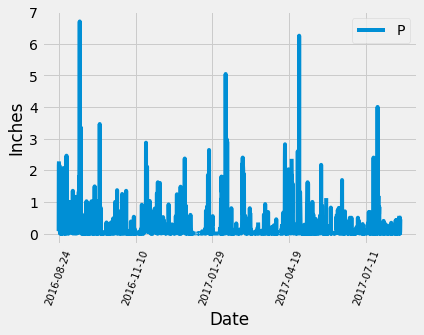

In [46]:
# Sort the dataframe by date
sorted_date_prcp_df = date_prcp_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
sorted_date_prcp_df['Percipitation'].plot()
plt.xticks(rotation=70, fontsize=10)
plt.ylabel("Inches")
plt.legend('Percipitation')


In [47]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_date_prcp_df.describe()

,Percipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [48]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(measurement.station).group_by(measurement.station).all()
len(stations)

9

In [49]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
#Which station has the highest number of observations? 
session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).first()

('USC00519281', 2772)

In [51]:
#test for flask app
session.query(measurement.date, func.min(measurement.tobs), func.max(measurement.tobs),\
            func.avg(measurement.tobs)).filter(measurement.date >= '2016-08-23').all()

[('2017-05-23', 58.0, 87.0, 74.59058295964125)]

In [52]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(measurement.station, func.min(measurement.tobs), func.max(measurement.tobs),\
                          func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [53]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_station_results = session.query(measurement.date, measurement.tobs).\
            filter(measurement.date > '2016-08-23').\
            filter(measurement.station == 'USC00519281').\
            order_by(measurement.date).all()

In [57]:
#set the query result above to dataframe
temp_df = pd.DataFrame(temp_station_results, columns =['Date', 'Temp'])
date_temp_df = temp_df.set_index('Date')
date_temp_df

,Temp
Date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


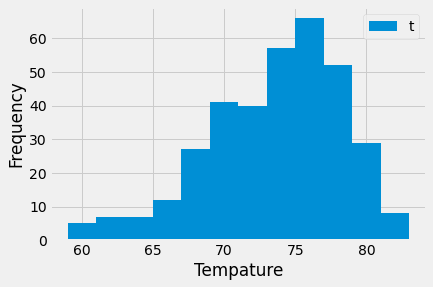

In [58]:
x = date_temp_df['Temp'].tolist()
plt.hist(x, bins = 12)
plt.ylabel("Frequency")
plt.xlabel("Tempature")
plt.legend('tobs')
plt.show()

## Bonus Challenge Assignment

In [56]:
# I did not complete bonus section


# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
